# Imports | Reads | Filter Patients

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_squared_log_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [2]:
# Read MIMICs CSV file
mimic_df = pd.read_csv("CSV\\exports\\final\\mimic_mean_final.csv")

# Read eICUs CSV file
eicu_df = pd.read_csv("CSV\\exports\\final\\eicu_mean_final.csv")

In [3]:
day = 10

# Filter icu stay less than 10 days
mimic_df = mimic_df[mimic_df['los'] < day]

# Filter icu stay less than 10 days
eicu_df = eicu_df[eicu_df['los'] < day]

In [4]:
# Filter Time Zone

#time_zone = 16
#mimic_df = mimic_df[mimic_df['Time_Zone'] == time_zone]
#eicu_df = eicu_df[eicu_df['Time_Zone'] == time_zone]

In [5]:
"""
I'm gonna concat and split the mimic and icu
at this point. I must create the same columns
from the tranformation of categorical data.
"""
row_count = mimic_df.shape[0]
print(f"Row count: {row_count}")

Row count: 48992


In [6]:
# Concat dataframes
df_combined = pd.concat([mimic_df, eicu_df], ignore_index=True)

# Find all categorical columns in mimic
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_combined, columns=categorical_columns)

# Split the concatenate dataframe
mimic_df = df_encoded.iloc[:row_count, :]
eicu_df = df_encoded.iloc[row_count:, :]

# Split Training - Validation - Test Set

In [7]:
total_test_val_perc = 0.2
split_between_test_val_perc = 0.5

# Group data by subject_id and hadm_id
grouped_df = mimic_df.groupby(['subject_id', 'hadm_id'])

# Get a new dataframe with one row per patient (subject_id, hadm_id) pair
patient_df = grouped_df['hospital_expire_flag'].first().reset_index()

# Split the patient_df into training (80%), validation (10%), and test (10%) while keeping the ratio of hospital_expired_flag
train, temp = train_test_split(patient_df, test_size=total_test_val_perc, stratify=patient_df['hospital_expire_flag'], random_state=42)
val, test = train_test_split(temp, test_size=split_between_test_val_perc, stratify=temp['hospital_expire_flag'], random_state=42)

# Step 4: Merge back with the original df to get the rows for each patient in the splits
train_df = mimic_df.merge(train[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
val_df = mimic_df.merge(val[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
test_df = mimic_df.merge(test[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Check the sizes of the splits
print(f'Training set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

Training set size: 39184
Validation set size: 4896
Test set size: 4912


# Check ratio and unique patients between sets

In [8]:
# Count on Training set survive and non-survive
survival_counts = train_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'Train Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = val_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nValidation Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = test_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nTest Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

Train Set
Survive: 1949.0
Non-survive: 500.0
Ratio Train Set: 3.90:1

Validation Set
Survive: 244.0
Non-survive: 62.0
Ratio Train Set: 3.94:1

Test Set
Survive: 244.0
Non-survive: 63.0
Ratio Train Set: 3.87:1


In [9]:
# Mine unique subject_id from sets
train_subjects = set(train_df['subject_id'].unique())
val_subjects = set(val_df['subject_id'].unique())
test_subjects = set(test_df['subject_id'].unique())

# Check if there are overlaping subject_id
train_val_overlap = train_subjects.intersection(val_subjects)
train_test_overlap = train_subjects.intersection(test_subjects)
val_test_overlap = val_subjects.intersection(test_subjects)

# Display the results
print(f'Overlap between training and validation sets: {len(train_val_overlap)}')
print(f'Overlap between training and test sets: {len(train_test_overlap)}')
print(f'Overlap between validation and test sets: {len(val_test_overlap)}')

# print overlaping
if train_val_overlap:
    print(f'Subjects in both training and validation: {train_val_overlap}')
if train_test_overlap:
    print(f'Subjects in both training and test: {train_test_overlap}')
if val_test_overlap:
    print(f'Subjects in both validation and test: {val_test_overlap}')

Overlap between training and validation sets: 0
Overlap between training and test sets: 0
Overlap between validation and test sets: 0


# Split label from Train - Validation - Test Sets

In [10]:
# External validation from eICU
X_external = eicu_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_external = eicu_df['los']

# Separate features and target for the training, validation, and test sets
X_train = train_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_train = train_df['los']

X_validate = val_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_validate = val_df['los']

X_test = test_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_test = test_df['los']

# Fill Missing Values by Mean

In [11]:
from sklearn.impute import SimpleImputer

# Create an imputer object and fit it to the training data
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Transform the validation and test sets using the same imputer
X_validate_imputed = imputer.transform(X_validate)
X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)

X_test_imputed = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Transform the external validation set using the same imputer
X_external_imputed = imputer.transform(X_external)
X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)

# Scale and Normalize

In [12]:
# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

# Optionally, apply Min-Max normalization
#X_train_normalized = X_train_scaled.copy()
#X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train_scaled[numerical_features])
#X_train = X_train_normalized


"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled

# Optionally, apply Min-Max normalization
#X_test_normalized = X_test_scaled.copy()
#X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test_scaled[numerical_features])
#X_test = X_test_normalized


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled

# Optionally, apply Min-Max normalization
#X_validate_normalized = X_validate_scaled.copy()
#X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate_scaled[numerical_features])
#X_validate = X_validate_normalized


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled

# Optionally, apply Min-Max normalization
#X_external_normalized = X_external_scaled.copy()
#X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external_scaled[numerical_features])
#X_external = X_external_normalized

# Fill Empty Training Cells using ANN

In [ ]:
# Fill training set missing values

# Step 1: Identify columns with missing values in X_train
missing_columns = X_train.columns[X_train.isnull().any()].tolist()
print(f"Columns with missing values: {missing_columns}")

# Step 2: Loop through each column with missing values and build an ANN to predict missing values
for col in missing_columns:
    print(f"Filling missing values in column: {col}")
    
    # Separate rows with and without missing values in the current column
    missing_rows = X_train[X_train[col].isnull()]
    non_missing_rows = X_train[~X_train[col].isnull()]
    
    # Skip the column if no data is available for training
    if len(missing_rows) == 0 or len(non_missing_rows) == 0:
        print(f"Skipping {col}, insufficient data")
        continue
    
    # Separate features and target for non-missing rows
    X_train_missing = non_missing_rows.drop(columns=missing_columns)  # Exclude other missing columns from features
    y_train_missing = non_missing_rows[col]  # Target is the column we're filling
    
    # Features for the rows with missing values (we'll predict the column for these rows)
    X_test_missing = missing_rows.drop(columns=missing_columns)
    
    # Step 3: Preprocess the data (Standard Scaling)
    scaler = StandardScaler()
    X_train_missing_scaled = scaler.fit_transform(X_train_missing)
    X_test_missing_scaled = scaler.transform(X_test_missing)
    
    # Step 4: Build the ANN model for filling missing values
    model_missing = Sequential()
    model_missing.add(Input(shape=(X_train_missing_scaled.shape[1],)))  # Use Input layer instead of input_shape in Dense
    model_missing.add(Dense(units=64, activation='relu'))
    model_missing.add(Dropout(0.3))
    model_missing.add(Dense(units=32, activation='relu'))
    model_missing.add(Dropout(0.3))
    model_missing.add(Dense(units=1, activation='linear'))  # Linear activation for regression tasks
    
    # Compile the model
    model_missing.compile(optimizer='adam', loss='mean_squared_error')
    
    # Step 5: Train the model
    model_missing.fit(X_train_missing_scaled, y_train_missing, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    
    # Step 6: Predict the missing values
    predicted_values = model_missing.predict(X_test_missing_scaled)
    
    # Step 7: Fill the missing values in X_train
    X_train.loc[X_train[col].isnull(), col] = predicted_values
    
    print(f"Filled missing values in column: {col}")

# Verify if there are any remaining missing values in X_train
print(X_train.isnull().sum())

In [ ]:
display (X_test)

# Fill Empty Training Cells by Interpolation

In [ ]:
X_train.interpolate(method='linear', inplace=True)

# Fill Empty Cells of Train - Validate - Test "Model-Based Imputation"

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# List of columns with missing values
missing_cols = X_train.columns[X_train.isna().any()].tolist()

# Dictionary to hold imputation models
imputation_models = {}

# Step through each column with missing values
for col in missing_cols:
    # Separate the data with missing values
    X_train_missing = X_train[X_train[col].isna()]
    X_train_non_missing = X_train.dropna(subset=[col])
    
    # Prepare the data for training
    X_train_non_missing_features = X_train_non_missing.drop(col, axis=1)
    y_train_non_missing = X_train_non_missing[col]
    
    # Train a RandomForestRegressor model to predict missing values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_non_missing_features, y_train_non_missing)
    
    # Predict missing values in the training set
    X_train_missing_features = X_train_missing.drop(col, axis=1)
    X_train.loc[X_train[col].isna(), col] = model.predict(X_train_missing_features)
    
    # Store the model for later use
    imputation_models[col] = model

# Apply the same imputation models to validation and test sets
for col, model in imputation_models.items():
    # Predict and fill missing values in validation and test sets
    X_validate_missing = X_validate[X_validate[col].isna()]
    X_validate_non_missing_features = X_validate.dropna(subset=[col]).drop(col, axis=1)
    X_validate[col].loc[X_validate[col].isna()] = model.predict(X_validate_missing.drop(col, axis=1))
    
    X_test_missing = X_test[X_test[col].isna()]
    X_test_non_missing_features = X_test.dropna(subset=[col]).drop(col, axis=1)
    X_test[col].loc[X_test[col].isna()] = model.predict(X_test_missing.drop(col, axis=1))

In [ ]:
display (X_train)

# Train Model without HP

In [13]:
# Default XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Train Model with HP RandomizedSearchCV

In [ ]:
# Define the hyperparameter distributions
param_dist = {
    'learning_rate': np.arange(0.01, 1.01, 0.1),
    'max_depth': np.arange(1, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1),
    'n_estimators': [100, 200, 300]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV with tqdm integration
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                    param_distributions=param_dist, 
                                    n_iter=100,  # Number of random samples to try
                                    scoring='neg_mean_squared_error',  # Use negative MSE for minimization
                                    cv=2,  # Number of folds for cross-validation
                                    n_jobs=-1,  # Use all available cores
                                    verbose=1,  # Print progress
                                    random_state=42)  # Set seed for reproducibility

# Perform the RandomizedSearchCV
with tqdm(total=100, desc="Hyperparameter Tuning") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(100)

# Retrieve the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best hyperparameters: {best_params}")
print(f"Best validation MSE: {best_score}")

# Predict on the test set with the best model
y_pred_test = best_model.predict(X_test)

# Predict on the external validation set with the best model
y_pred_external = best_model.predict(X_external)

# Evaluation on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test) * 100

print(f"Test Set MSE: {mse_test}")
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R2 Score: {r2_test}")

# Evaluation on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set R2 Score: {r2_external}")

# Train Model with HP gridsearchcv

In [ ]:
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# Define the hyperparameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 1.01, 0.3),
    'max_depth': np.arange(1, 11, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1),
    'n_estimators': [100, 200, 300]  # Keep n_estimators as is
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV with tqdm integration
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Use negative MSE for minimization
                           cv=2,  # Number of folds for cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=1)  # Disable default verbosity

# Perform the GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

print(f"Best hyperparameters: {best_params}")
print(f"Best validation MSE: {best_score}")

# Predict on the test set with the best model
y_pred_test = best_model.predict(X_test)

# Predict on the external validation set with the best model
y_pred_external = best_model.predict(X_external)

# Evaluation on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test) * 100

print(f"Test Set MSE: {mse_test}")
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set MAE: {mae_test}")
print(f"Test Set R2 Score: {r2_test}")

# Evaluation on the external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
rmse_external = root_mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set R2 Score: {r2_external}")

# Save dataframes

In [14]:
# Path
save_path = 'CSV/exports/impute/all_features/o3_mean_scale_impute/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'X_external.csv', index=False)
y_external.to_csv(save_path + 'y_external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'X_train.csv', index=False)
y_train.to_csv(save_path + 'y_train.csv', index=False)

X_validate.to_csv(save_path + 'X_validate.csv', index=False)
y_validate.to_csv(save_path + 'y_validate.csv', index=False)

X_test.to_csv(save_path + 'X_test.csv', index=False)
y_test.to_csv(save_path + 'y_test.csv', index=False)

# Save Model

In [15]:
# Define the directory and file path

name = 'o3_mean_impute_scale_default_xgboost.json'
directory = 'models'

file_path = os.path.join(directory, name)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the model as a JSON file
model.save_model(file_path)

# Test Set Plots

Test Set MSE: 9.61404104430596
Test Set MAE: 2.691200096810025
Test Set RMSE: 3.100651712834894
Test Set R2: -79.52413224634437
Test Set MSLE: 0.5380779098691134


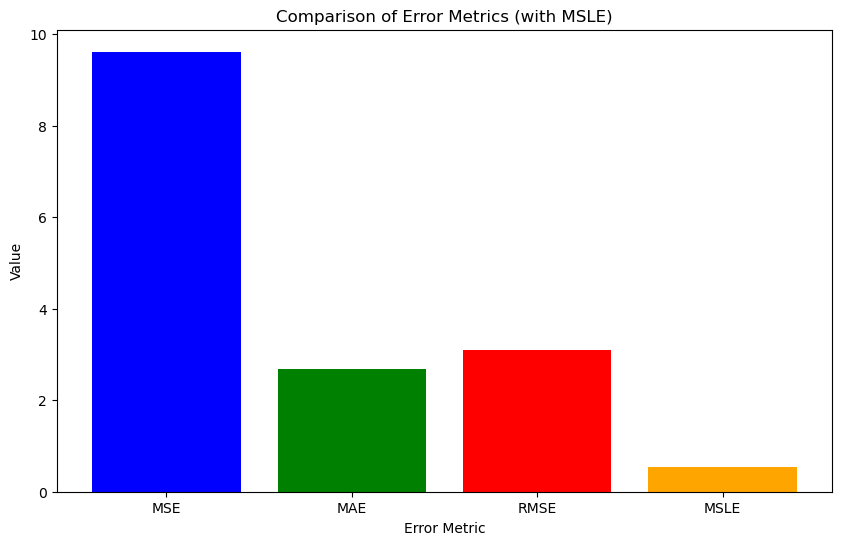

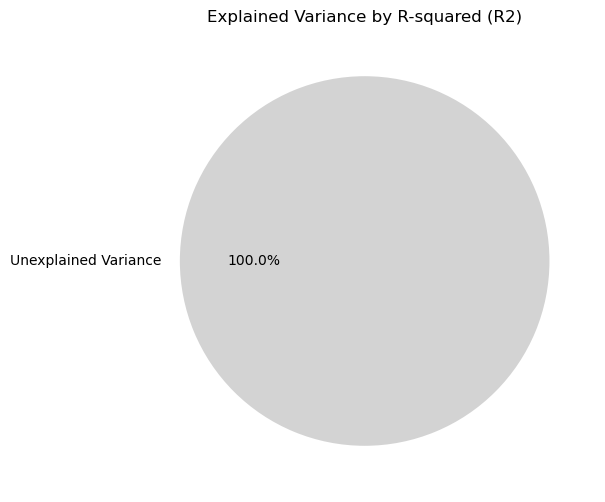

In [16]:
# Metrics calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) * 100

print(f"Test Set MSE: {mse}")
print(f"Test Set MAE: {mae}")
print(f"Test Set RMSE: {rmse}")
print(f"Test Set R2: {r2}")

# Plotting MSLE if applicable
try:
    msle = mean_squared_log_error(y_test, y_pred)
    print(f"Test Set MSLE: {msle}")
    
    # Adding MSLE to the bar plot
    error_metrics = ['MSE', 'MAE', 'RMSE', 'MSLE']
    values = [mse, mae, rmse, msle]
    
    # Plot updated error metrics with MSLE
    plt.figure(figsize=(10, 6))
    plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'])  # Added orange for MSLE
    plt.xlabel('Error Metric')
    plt.ylabel('Value')
    plt.title('Comparison of Error Metrics (with MSLE)')
    plt.show()

except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Explained Variance by R-squared (R2)')
plt.show()

# External Validation Plots

External Validation Set MSE: 7.545836143746585
External Validation Set MAE: 2.3389517602042416
External Validation Set RMSE: 2.7469685370871257
External Validation Set R2: -57.508860158238285
Test Set MSLE: 0.5380779098691134


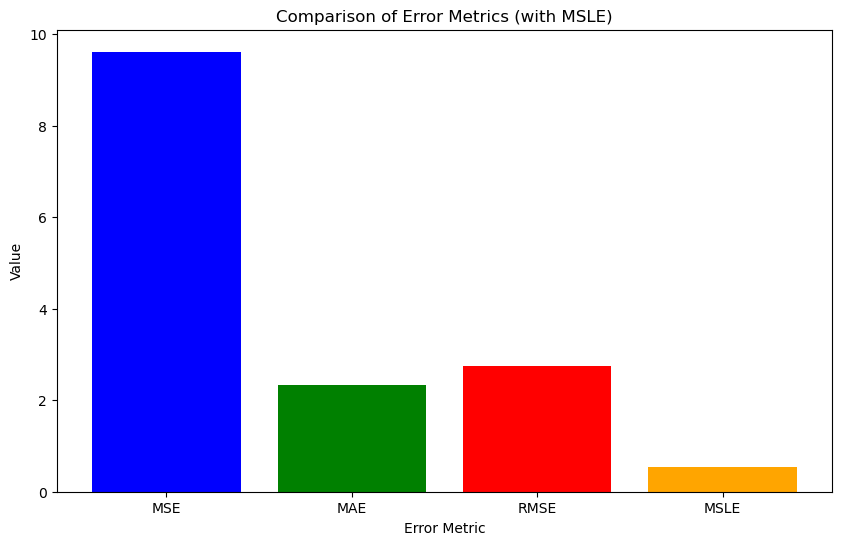

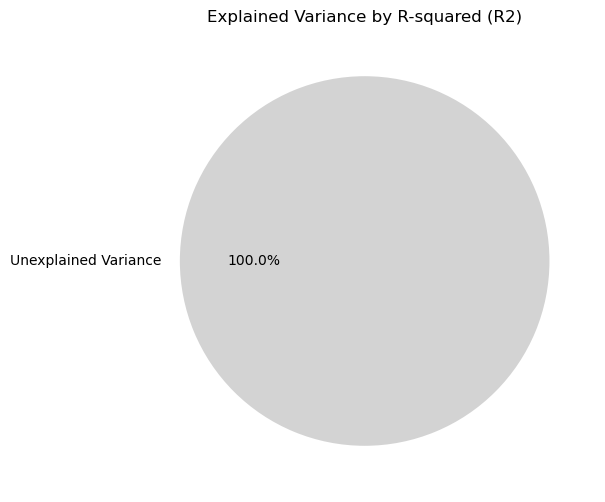

In [17]:
# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set R2: {r2_external}")

# Plotting MSLE if applicable
try:
    msle_external = mean_squared_log_error(y_test, y_pred)
    print(f"Test Set MSLE: {msle_external}")
    
    # Adding MSLE to the bar plot
    error_metrics = ['MSE', 'MAE', 'RMSE', 'MSLE']
    values = [mse, mae_external, rmse_external, msle_external]
    
    # Plot updated error metrics with MSLE
    plt.figure(figsize=(10, 6))
    plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'])  # Added orange for MSLE
    plt.xlabel('Error Metric')
    plt.ylabel('Value')
    plt.title('Comparison of Error Metrics (with MSLE)')
    plt.show()

except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Explained Variance by R-squared (R2)')
plt.show()


# Most important features

In [18]:
# Get feature importances
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Scale the importance
most_important_df['Importance'] *= 100000

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                      Feature   Importance
3                                        pCO2  7487.332076
70                                Haptoglobin  4508.816823
64               Reticulocyte Count Automated  4400.856793
54                           Serum Osmolality  3887.252882
46                                    Albumin  3792.394325
45                            Ionized Calcium  2936.776169
42                                 Pain Level  2673.926018
58                   C Reactive Protein (CRP)  2272.031829
59                                 Fibrinogen  2038.932964
11            Asparate Aminotransferase (AST)  2021.178603
67                        Differential-Lymphs  1982.480474
51    Arterial Blood Pressure systolic (mmHg)  1812.846400
75                                    Amylase  1743.622124
69                         Differential-Neuts  1685.846038
49                                        LDH  1600.431465
71                      

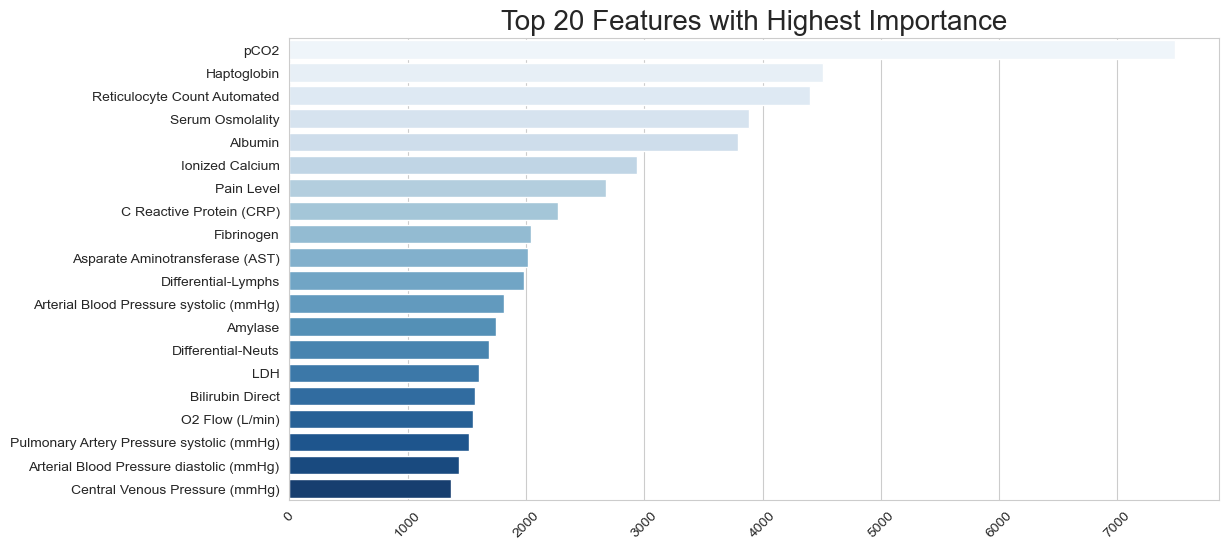

In [19]:
# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 10 most important features
top_10_features = most_important_df.head(20)

# Plotting
plt.figure(figsize=(12, 6))  # Reduce figure size
plot = sns.barplot(x='Importance', y='Feature', data=top_10_features, hue='Feature', palette="Blues", legend=False)

# Reduce font size slightly 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.title('Top 20 Features with Highest Importance', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.ylabel('')
plt.xlabel('')

# Save the plot in high resolution
#plt.savefig('plots/top_20_most_important_features.jpeg', dpi=300)
plt.show()